# Import libraries that are needed to read in data

In [146]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.linear_model import LogisticRegression
from sklearn.cross_validation import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz

# Read in Data

In [4]:
slug_results = pd.read_csv('Data Science Results.csv',header = None)

In [5]:
slug_results.columns = ['PK','SchoolName','Season','Game_Num','Date','Home_Team','Away_Team', 'Hitting_Team'
                        ,'Inning','AB','Result','Count','Pitch_Seq','BIP_Location','PlayerName'
                       , 'AB_Length','Sport','ConferenceName','IsBunt']

In [6]:
slug_results.shape

(785031, 19)

# Create dataframe that looks at data that should be influential in determining the result of an at bat

We are are limiting the data to at bats where you have a pitch sequence (so you can figure out what counts were experienced in the at bat), getting rid of bad data (counts where the final count doesn't make sense), and not including results that aren't really influential from a count (catchers interferance, batters interfearance, sac bunts, and hit by pitches)

In [7]:
pitch_seq_df = slug_results[(((pd.isnull(slug_results['Pitch_Seq']) == True) & (slug_results['Count'] == '0-0')) 
             | 
             (pd.isnull(slug_results['Pitch_Seq']) == False))
            & (~slug_results['Count'].isin(['2-3', '9-4', '3)', '1-5', '1-3', '4-5', '2-6', '2-4']))
            & (~slug_results['Result'].isin(['CI','BI','SB','SACB','HBP']))][['Result','Count','Pitch_Seq']]

In [9]:
pitch_seq_df.head()

,Result,Count,Pitch_Seq
249,GO,1-0,B
250,FLYO,0-0,NaN
251,ROE,2-1,KBB
253,2B,0-1,K
254,1B,0-1,F


In [114]:
# Get the list of the different available counts
count_list = list(pitch_seq_df.Count.value_counts().keys())
count_list.sort()
count_list

['0-0',
 '0-1',
 '0-2',
 '1-0',
 '1-1',
 '1-2',
 '2-0',
 '2-1',
 '2-2',
 '3-0',
 '3-1',
 '3-2']

## Create all of the different functions that can break out each at bat into the count, final ball and strikes, and result of the at bat.

In [10]:
##############################################################
#Zero ball counts
##############################################################

def oh_one(row):
    pitch_seq = row['Pitch_Seq']
    strikes = ['K','S','F']
    if pd.isnull(pitch_seq) == True:
        return 0
    if pitch_seq[0] in strikes:
        return 1
    else:
        return 0
    
def oh_two(row):
    pitch_seq = row['Pitch_Seq']
    strikes = ['K','S','F']
    if pd.isnull(pitch_seq) == True:
        return 0
    if len(pitch_seq) < 2:
        return 0
    else:
        if pitch_seq[0] in strikes and pitch_seq[1] in strikes:
            return 1
        else:
            return 0

##############################################################
#One ball counts
##############################################################
def one_oh(row):
    pitch_seq = row['Pitch_Seq']
    if pd.isnull(pitch_seq) == True:
        return 0
    if pitch_seq[0] == "B":
        return 1
    else:
        return 0
    
def one_one(row):
    s_cnt = 0
    b_cnt = 0
    pitch_seq = row['Pitch_Seq']
    strikes = ['K','S','F']
    if pd.isnull(pitch_seq) == True:
        return 0
    if len(pitch_seq) < 2:
        return 0
    for pitch in range(2):
        if pitch_seq[pitch] in strikes:
            s_cnt +=1
        else:
            b_cnt +=1
    if s_cnt ==1 and b_cnt == 1:
        return 1
    else:
        return 0
    
def one_two(row):
    s_cnt = 0
    b_cnt = 0
    pitch_seq = row['Pitch_Seq']
    strikes = ['K','S','F']
    if pd.isnull(pitch_seq) == True:
        return 0
    if len(pitch_seq) < 3:
        return 0
    for pitch in range(3):
        if pitch_seq[pitch] in strikes:
            s_cnt +=1
        else:
            b_cnt +=1
    if s_cnt ==2 and b_cnt == 1:
        return 1
    else:
        return 0
    
##############################################################
#Two ball counts
##############################################################
def two_oh(row):
    pitch_seq = row['Pitch_Seq']
    if pd.isnull(pitch_seq) == True:
        return 0
    if len(pitch_seq) < 2:
        return 0
    else:
        if pitch_seq[0:2] == 'BB':
            return 1
        else:
            return 0
    
def two_one(row):
    s_cnt = 0
    b_cnt = 0
    pitch_seq = row['Pitch_Seq']
    strikes = ['K','S','F']
    if pd.isnull(pitch_seq) == True:
        return 0
    if len(pitch_seq) < 3:
        return 0
    for pitch in range(3):
        if pitch_seq[pitch] in strikes:
            s_cnt +=1
        else:
            b_cnt +=1
    if s_cnt ==1 and b_cnt == 2:
        return 1
    else:
        return 0
    
def two_two(row):
    s_cnt = 0
    b_cnt = 0
    pitch_seq = row['Pitch_Seq']
    strikes = ['K','S','F']
    if pd.isnull(pitch_seq) == True:
        return 0
    if len(pitch_seq) < 4:
        return 0
    for pitch in range(4):
        if pitch_seq[pitch] in strikes:
            s_cnt +=1
        else:
            b_cnt +=1
    if s_cnt ==2 and b_cnt == 2:
        return 1
    else:
        return 0
    
##############################################################
#Three ball counts
##############################################################
def three_oh(row):
    pitch_seq = row['Pitch_Seq']
    if pd.isnull(pitch_seq) == True:
        return 0
    if len(pitch_seq) < 3:
        return 0
    else:
        if pitch_seq[0:3] == 'BBB':
            return 1
        else:
            return 0

def three_one(row):
    s_cnt = 0
    b_cnt = 0
    pitch_seq = row['Pitch_Seq']
    strikes = ['K','S','F']
    if pd.isnull(pitch_seq) == True:
        return 0
    if len(pitch_seq) < 4:
        return 0
    for pitch in range(4):
        if pitch_seq[pitch] in strikes:
            s_cnt +=1
        else:
            b_cnt +=1
    if s_cnt ==1 and b_cnt == 3:
        return 1
    else:
        return 0
    
def three_two(row):
    s_cnt = 0
    b_cnt = 0
    pitch_seq = row['Pitch_Seq']
    strikes = ['K','S','F']
    if pd.isnull(pitch_seq) == True:
        return 0
    if len(pitch_seq) < 5:
        return 0
    for pitch in range(5):
        if pitch_seq[pitch] in strikes:
            s_cnt +=1
        else:
            b_cnt +=1
    if s_cnt ==2 and b_cnt == 3:
        return 1
    else:
        return 0
    
##############################################################
# Length of at bat
##############################################################

def ab_length(row):
    pitch_seq = row['Pitch_Seq']
    r = row['Result']
    if pd.isnull(pitch_seq) == True:
        return 1
    elif r in ['BB','KS','KL','K']:
        return len(pitch_seq)
    else:
        return len(pitch_seq) + 1
    
    
##############################################################
# Strikes in count
##############################################################

def num_of_strikes(row):
    cnt = row['Count']
    return int(cnt.split('-')[1])

##############################################################
# Balls in bat
##############################################################

def num_of_balls(row):
    cnt = row['Count']
    return int(cnt.split('-')[0])

##############################################################
# If at bat ended in hit
##############################################################

def isHit(row):
    r = row['Result']
    if r in ['1B','2B','3B','HR']:
        return 1
    else:
        return 0

##############################################################
# If at bat ended in getting on base
##############################################################
def OnBase(row):
    r = row['Result']
    if r in ['1B','2B','3B','HR', 'BB']:
        return 1
    else:
        return 0

In [11]:
pitch_seq_df['OnBase'] = pitch_seq_df.apply(OnBase, axis = 1)
pitch_seq_df['NumOfBalls'] = pitch_seq_df.apply(num_of_balls, axis = 1)
pitch_seq_df['NumOfStrikes'] = pitch_seq_df.apply(num_of_strikes, axis = 1)
pitch_seq_df['0-1'] = pitch_seq_df.apply(oh_one,axis = 1)
pitch_seq_df['0-2'] = pitch_seq_df.apply(oh_two,axis = 1)
pitch_seq_df['1-0'] = pitch_seq_df.apply(one_oh,axis = 1)
pitch_seq_df['1-1'] = pitch_seq_df.apply(one_one,axis = 1)
pitch_seq_df['1-2'] = pitch_seq_df.apply(one_two,axis = 1)
pitch_seq_df['2-0'] = pitch_seq_df.apply(two_oh,axis = 1)
pitch_seq_df['2-1'] = pitch_seq_df.apply(two_one,axis = 1)
pitch_seq_df['2-2'] = pitch_seq_df.apply(two_two,axis = 1)
pitch_seq_df['3-0'] = pitch_seq_df.apply(three_oh,axis = 1)
pitch_seq_df['3-1'] = pitch_seq_df.apply(three_one,axis = 1)
pitch_seq_df['3-2'] = pitch_seq_df.apply(three_two,axis = 1)
pitch_seq_df['Ab_Length'] = pitch_seq_df.apply(ab_length, axis = 1)

In [12]:
pitch_seq_df.head()

,Result,Count,Pitch_Seq,OnBase,NumOfBalls,NumOfStrikes,0-1,0-2,1-0,1-1,1-2,2-0,2-1,2-2,3-0,3-1,3-2,Ab_Length
249,GO,1-0,B,0,1,0,0,0,1,0,0,0,0,0,0,0,0,2
250,FLYO,0-0,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
251,ROE,2-1,KBB,0,2,1,1,0,0,1,0,0,1,0,0,0,0,4
253,2B,0-1,K,1,0,1,1,0,0,0,0,0,0,0,0,0,0,2
254,1B,0-1,F,1,0,1,1,0,0,0,0,0,0,0,0,0,0,2


# Which count results in the highest on base percentages:

In [18]:
obp_mat = pd.DataFrame(columns = ['Ball','Strike','OBP'])
obp_mat = obp_mat.append(pd.DataFrame([[0,0,pitch_seq_df['OnBase'].mean()]], columns = ['Ball','Strike','OBP']))

for ab_count in pitch_seq_df.columns[6:-1]:
    print(ab_count)
    print([int(ab_count[0]), int(ab_count[2]),pitch_seq_df[pitch_seq_df[ab_count] == 1]['OnBase'].mean() ])
    obp_mat = obp_mat.append(pd.DataFrame([[int(ab_count[0]), int(ab_count[2]), pitch_seq_df[pitch_seq_df[ab_count] == 1]['OnBase'].mean()]]
                                         , columns = ['Ball','Strike','OBP']))

0-1
[0, 1, 0.29801066273431076]
0-2
[0, 2, 0.2249139359938799]
1-0
[1, 0, 0.4210703517211968]
1-1
[1, 1, 0.34389310690165803]
1-2
[1, 2, 0.2565221452686924]
2-0
[2, 0, 0.5441929756535581]
2-1
[2, 1, 0.438515329180408]
2-2
[2, 2, 0.3299381332376939]
3-0
[3, 0, 0.7677779697126734]
3-1
[3, 1, 0.6303196580105914]
3-2
[3, 2, 0.4969614688388932]


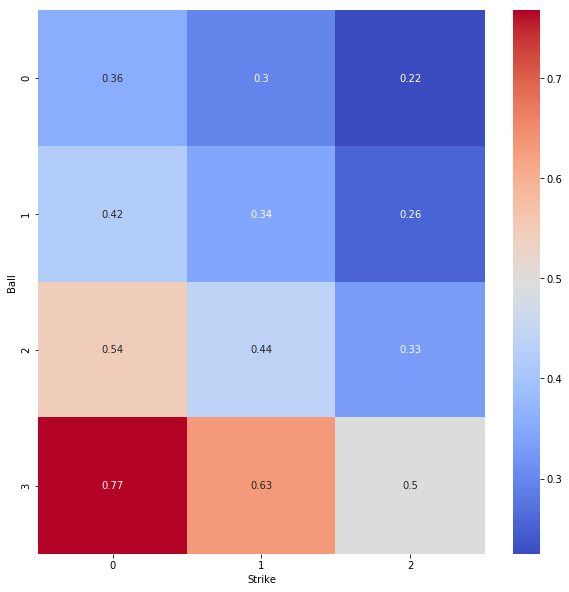

In [23]:
plt.figure(figsize = (10,10))
sns.heatmap(obp_mat.pivot('Ball','Strike'), annot=True, xticklabels=[0,1,2], cmap='coolwarm');
plt.ylabel('Ball');
plt.xlabel('Strike');

It looks like there are 3 sections to be aware of:

Not good:  Dark Blue Blue

Decent: Light blue and grey

Very good: Orange and Red

# Which counts have the biggest impact on whether you will get on base in an at bat or not

In [36]:
# Look to see which at bats have the biggest swing of on base percentages
spread_df = pd.DataFrame(columns = ['Count','Total Spread'])

print('0-0 :', pitch_seq_df['OnBase'].mean())
print('    Ball up 1-0:', round(pitch_seq_df[pitch_seq_df['1-0'] == 1]['OnBase'].mean(),3) 
     , 'Value Difference:', pitch_seq_df[pitch_seq_df['1-0'] == 1]['OnBase'].mean() - pitch_seq_df['OnBase'].mean() 
     )
print('    Strike up 0-1:', round(pitch_seq_df[pitch_seq_df['0-1'] == 1]['OnBase'].mean(), 3)
     , 'Value Difference:', pitch_seq_df[pitch_seq_df['0-1'] == 1]['OnBase'].mean() -pitch_seq_df['OnBase'].mean() 
     )
print('    Total Spread:', abs(pitch_seq_df['OnBase'].mean() - pitch_seq_df[pitch_seq_df['0-1'] == 1]['OnBase'].mean())
     + abs(pitch_seq_df['OnBase'].mean() - pitch_seq_df[pitch_seq_df['1-0'] == 1]['OnBase'].mean()))
spread_df = spread_df.append({'Count':'0-0'
    , 'Total Spread': abs(pitch_seq_df['OnBase'].mean() - pitch_seq_df[pitch_seq_df['0-1'] == 1]['OnBase'].mean())
     + abs(pitch_seq_df['OnBase'].mean() - pitch_seq_df[pitch_seq_df['1-0'] == 1]['OnBase'].mean())}
    , ignore_index = True)


for cnt in pitch_seq_df.columns[6:-1]:
    
    #print(cnt)
    obp = round(pitch_seq_df[pitch_seq_df[cnt] == 1]['OnBase'].mean(),3)
    print(cnt, ':', obp)
    ball_count = int(cnt[0])
    strike_count = int(cnt[2])
    fin_criteria = 0
    
    if ball_count < 3:
        ball_count +=1
        new_ball_count = str(ball_count) + '-' + str(strike_count)
        new_ball_obp = round(pitch_seq_df[pitch_seq_df[new_ball_count] == 1]['OnBase'].mean(),3)
        print('    Ball up', new_ball_count,':', new_ball_obp, ', Value Difference:', new_ball_obp - obp)
        fin_criteria +=1
        ball_count -=1
        
    if strike_count < 2:
        strike_count += 1
        new_strike_count = str(ball_count) + '-' + str(strike_count)
        new_strike_obp = round(pitch_seq_df[pitch_seq_df[new_strike_count] == 1]['OnBase'].mean(),3)
        print('    Strike up', new_strike_count, ':', new_strike_obp, ',  Value Difference:', new_strike_obp - obp)
        fin_criteria +=1
        strike_count -=1
    
    if fin_criteria == 2:
        print('        Total Spread:', abs(new_strike_obp - obp) + abs(new_ball_obp - obp))
        spread_df = spread_df.append({'Count':cnt, 
                                      'Total Spread':abs(new_strike_obp - obp) + abs(new_ball_obp - obp)}
                                    , ignore_index = True)

0-0 : 0.35803202370882303
    Ball up 1-0: 0.421 Value Difference: 0.06303832801237375
    Strike up 0-1: 0.298 Value Difference: -0.06002136097451227
    Total Spread: 0.12305968898688602
0-1 : 0.298
    Ball up 1-1 : 0.344 , Value Difference: 0.045999999999999985
    Strike up 0-2 : 0.225 ,  Value Difference: -0.07299999999999998
        Total Spread: 0.11899999999999997
0-2 : 0.225
    Ball up 1-2 : 0.257 , Value Difference: 0.032
1-0 : 0.421
    Ball up 2-0 : 0.544 , Value Difference: 0.12300000000000005
    Strike up 1-1 : 0.344 ,  Value Difference: -0.07700000000000001
        Total Spread: 0.20000000000000007
1-1 : 0.344
    Ball up 2-1 : 0.439 , Value Difference: 0.09500000000000003
    Strike up 1-2 : 0.257 ,  Value Difference: -0.08699999999999997
        Total Spread: 0.182
1-2 : 0.257
    Ball up 2-2 : 0.33 , Value Difference: 0.07300000000000001
2-0 : 0.544
    Ball up 3-0 : 0.768 , Value Difference: 0.22399999999999998
    Strike up 2-1 : 0.439 ,  Value Difference: -0.105

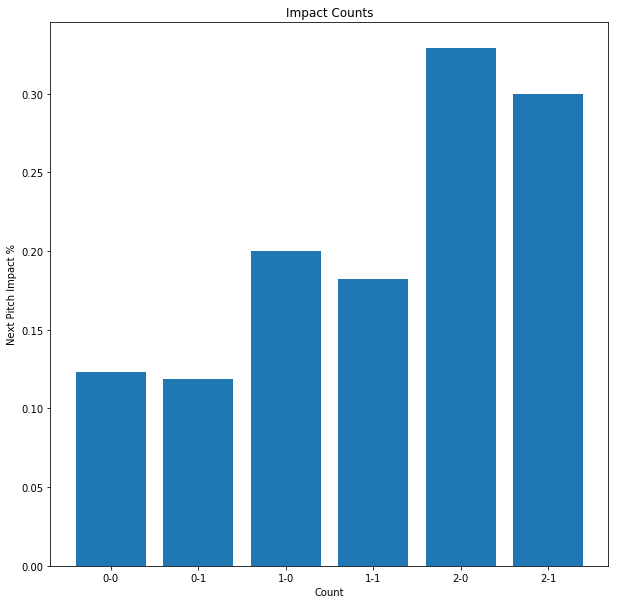

In [129]:
plt.figure(figsize=(10,10))
plt.bar(spread_df['Count'].values, spread_df['Total Spread'].values);
plt.title('Impact Counts');
plt.ylabel('Next Pitch Impact %');
plt.xlabel('Count');

# How do count's affect power numbers


We can look at this at two different angles: 

1) Are there specific counts that show which type of extra base hit based on the count

2) Look at the "slugging metric" to determine which count will result in better power numbers

In [53]:
def slug(row):
    r = row['Result']
    if r == 'BB' or r == '1B':
        return 1
    elif r == '2B':
        return 2
    elif r == '3B':
        return 3
    elif r == 'HR':
        return 4
    else:
        return 0
    
pitch_seq_df['TotalBases'] = pitch_seq_df.apply(slug, axis = 1)

In [54]:
pitch_seq_df.head()

,Result,Count,Pitch_Seq,OnBase,NumOfBalls,NumOfStrikes,0-1,0-2,1-0,1-1,1-2,2-0,2-1,2-2,3-0,3-1,3-2,Ab_Length,TotalBases
249,GO,1-0,B,0,1,0,0,0,1,0,0,0,0,0,0,0,0,2,0
250,FLYO,0-0,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
251,ROE,2-1,KBB,0,2,1,1,0,0,1,0,0,1,0,0,0,0,4,0
253,2B,0-1,K,1,0,1,1,0,0,0,0,0,0,0,0,0,0,2,2
254,1B,0-1,F,1,0,1,1,0,0,0,0,0,0,0,0,0,0,2,1


In [57]:
# The slugging percentage in each count
(
    pitch_seq_df.groupby(['Count'], as_index = False).mean()[['Count','TotalBases']]
).sort_values(['TotalBases'], ascending = False)

,Count,TotalBases
9,3-0,0.983851
10,3-1,0.827490
6,2-0,0.583957
11,3-2,0.579437
3,1-0,0.552647
7,2-1,0.545120
0,0-0,0.525133
4,1-1,0.504097
1,0-1,0.485105
8,2-2,0.306513


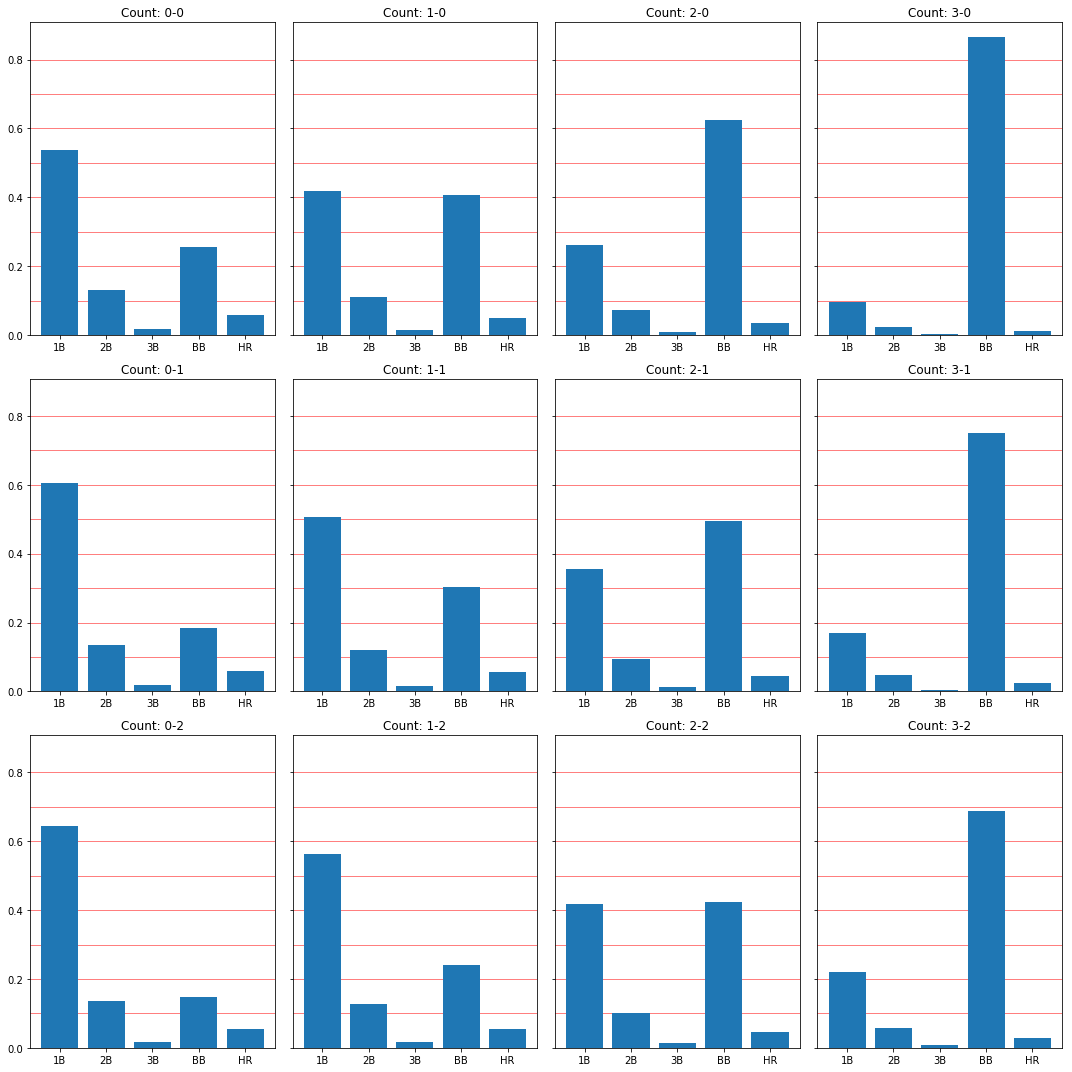

In [130]:
f, axarr = plt.subplots(3, 4,figsize=(15,15),sharey=True)
x_ax = 0
y_ax = 0
for cnt in count_list:
    if cnt == '0-0':
        ab_result = pitch_seq_df[pitch_seq_df['Result'].isin(['BB','1B','2B','3B','HR'])]['Result'].value_counts(normalize = True)
    else:
        ab_result = pitch_seq_df[(pitch_seq_df[cnt] == 1) 
             & (pitch_seq_df['Result'].isin(['BB','1B','2B','3B','HR']))]['Result'].value_counts(normalize = True)
    axarr[x_ax, y_ax].bar(list(ab_result.keys()), list(ab_result.values));
    axarr[x_ax, y_ax].set_title('Count: ' + cnt)
    for l in range(1,9):
        axarr[x_ax, y_ax].axhline(y= l / 10, c="red",linewidth=0.5,zorder=0)
    if x_ax < 2:
        x_ax +=1
    else:
        x_ax = 0
        y_ax +=1
plt.tight_layout()

# Machine learning to predict successful results

In [159]:
ml_df = pitch_seq_df.iloc[:,3:-1].sample(frac = 1)
ml_df.head()

,OnBase,NumOfBalls,NumOfStrikes,0-1,0-2,1-0,1-1,1-2,2-0,2-1,2-2,3-0,3-1,3-2,Ab_Length
309796,0,0,1,1,0,0,0,0,0,0,0,0,0,0,2
474052,0,2,2,1,1,0,0,1,0,0,1,0,0,0,5
466227,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
744040,0,1,1,1,0,0,1,0,0,0,0,0,0,0,3
536166,0,1,1,1,0,0,1,0,0,0,0,0,0,0,3


In [160]:
X_train, X_test, y_train, y_test = train_test_split(
                          ml_df.iloc[:,1:]
                        , ml_df.iloc[:,0]
                        , random_state=534)

In [161]:
dt_cf = DecisionTreeClassifier(criterion="gini", random_state=534, max_depth=2)
dt_cf.fit(X_train,y_train)
print('Train Baseline Estimator',1 -  y_train.mean())
print('Test Baseline Estimator', 1 - y_test.mean())
print('Training Accuracy', accuracy_score(y_train, dt_cf.predict(X_train)))
print('Testing Accuracy', accuracy_score(y_test, dt_cf.predict(X_test)))
export_graphviz(dt_cf, out_file='dc_cf_slugger.dot', feature_names=X_train.columns, class_names=['Out','On Base'])   

Train Baseline Estimator 0.6422792191430731
Test Baseline Estimator 0.6410342552042714
Training Accuracy 0.6876172345250426
Testing Accuracy 0.6867718519407283


In [164]:
rf_clf = RandomForestClassifier(n_estimators=150, random_state=534)
rf_clf.fit(X_train,y_train)
print('Train Baseline Estimator',1 -  y_train.mean())
print('Test Baseline Estimator', 1 - y_test.mean())
print('Training Accuracy', accuracy_score(y_train, rf_clf.predict(X_train)))
print('Testing Accuracy', accuracy_score(y_test, rf_clf.predict(X_test)))

Train Baseline Estimator 0.6422792191430731
Test Baseline Estimator 0.6410342552042714
Training Accuracy 0.6900849087920394
Testing Accuracy 0.6878756974023637


In [163]:
log_cf = LogisticRegression(random_state=534)
log_cf.fit(X_train,y_train)
print('Train Baseline Estimator',1 -  y_train.mean())
print('Test Baseline Estimator', 1 - y_test.mean())
print('Training Accuracy', accuracy_score(y_train, log_cf.predict(X_train)))
print('Testing Accuracy', accuracy_score(y_test, log_cf.predict(X_test)))

Train Baseline Estimator 0.6422792191430731
Test Baseline Estimator 0.6410342552042714
Training Accuracy 0.6873492698963737
Testing Accuracy 0.6868078469014338


## The random forrest model did the best, but it was not much better than the simple classifiers

We can look at the feature importances to see what columns had the biggest influences in determining what determined whether or not it would be a successful at bat or not

In [167]:
rf_clf = RandomForestClassifier(n_estimators=150, random_state=534)
rf_clf.fit(X_train,y_train)
print('Train Baseline Estimator',1 -  y_train.mean())
print('Test Baseline Estimator', 1 - y_test.mean())
print('Training Accuracy', accuracy_score(y_train, rf_clf.predict(X_train)))
print('Testing Accuracy', accuracy_score(y_test, rf_clf.predict(X_test)))

pd.DataFrame(list(zip(X_train.columns,rf_clf.feature_importances_)), columns = ['Column','Feature Importance']
            ).sort_values(['Feature Importance'], ascending = False)

Train Baseline Estimator 0.6422792191430731
Test Baseline Estimator 0.6410342552042714
Training Accuracy 0.6900809093199698
Testing Accuracy 0.6878517007618933


,Column,Feature Importance
0,NumOfBalls,0.311860
11,3-1,0.126041
10,3-0,0.123888
13,Ab_Length,0.112564
1,NumOfStrikes,0.111684
7,2-0,0.063465
12,3-2,0.053069
3,0-2,0.033217
6,1-2,0.024293
9,2-2,0.013619
